This notebook is for prototyping subnetwork flow.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim
from tqdm.auto import tqdm
from transformer_lens import HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

from pii import utils
from pii.subnet_flow.masked_model import PerTokenMaskedTransformer

# torch.set_grad_enabled(False)

### Load models

In [3]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
with torch.no_grad():
    print(
        tl_model.generate(
            "The capital of Germany is", max_new_tokens=20, temperature=0
        )
    )

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions


In [5]:
prompt = "The capital of Germany is"

mtf_test = PerTokenMaskedTransformer(tl_model, base_prompt=prompt)
print([n for n, p in mtf_test.named_parameters() if p.requires_grad])
with torch.no_grad():
    for name, mask in mtf_test.masks.items():
        if name == "31_mlp_out" or name == "31_attn_pattern":
            print(name, mask.shape)
            continue
        mask *= 0

with torch.no_grad():
    print(
        mtf_test.tl_model.generate(
            "The capital of Germany is",
            max_new_tokens=20,
            temperature=0,
            use_past_kv_cache=False,  # This is important!
        )
    )
    mtf_test.masks_active = False
    print(
        mtf_test.tl_model.generate(
            "The capital of Germany is",
            max_new_tokens=20,
            temperature=0,
            use_past_kv_cache=False,  # This is important!
        )
    )

mtf_test.masks_active = True
with torch.no_grad():
    _, cache = mtf_test.tl_model.run_with_cache(
        prompt,
        remove_batch_dim=True,
    )

assert torch.allclose(cache["resid_pre", 2], cache["resid_post", 30])
assert not torch.allclose(cache["resid_pre", 2], cache["resid_post", 31])
assert torch.allclose(cache["pattern", 2], cache["pattern", 30])
assert not torch.allclose(cache["pattern", 2], cache["pattern", 31])

['masks.0_attn_z', 'masks.0_attn_pattern', 'masks.0_attn_out', 'masks.0_mlp_out', 'masks.1_attn_z', 'masks.1_attn_pattern', 'masks.1_attn_out', 'masks.1_mlp_out', 'masks.2_attn_z', 'masks.2_attn_pattern', 'masks.2_attn_out', 'masks.2_mlp_out', 'masks.3_attn_z', 'masks.3_attn_pattern', 'masks.3_attn_out', 'masks.3_mlp_out', 'masks.4_attn_z', 'masks.4_attn_pattern', 'masks.4_attn_out', 'masks.4_mlp_out', 'masks.5_attn_z', 'masks.5_attn_pattern', 'masks.5_attn_out', 'masks.5_mlp_out', 'masks.6_attn_z', 'masks.6_attn_pattern', 'masks.6_attn_out', 'masks.6_mlp_out', 'masks.7_attn_z', 'masks.7_attn_pattern', 'masks.7_attn_out', 'masks.7_mlp_out', 'masks.8_attn_z', 'masks.8_attn_pattern', 'masks.8_attn_out', 'masks.8_mlp_out', 'masks.9_attn_z', 'masks.9_attn_pattern', 'masks.9_attn_out', 'masks.9_mlp_out', 'masks.10_attn_z', 'masks.10_attn_pattern', 'masks.10_attn_out', 'masks.10_mlp_out', 'masks.11_attn_z', 'masks.11_attn_pattern', 'masks.11_attn_out', 'masks.11_mlp_out', 'masks.12_attn_z', 

  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is are The The of The The The The The The The The of The of The The The The The


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions


### Load athlete data

In [6]:
athletes_list = list(set(pd.read_csv("../data/athletes.csv").name))
print("# of athletes:", len(athletes_list))

athletes_by_token_length = collections.defaultdict(list)
for athlete in athletes_list:
    # Tokenize the athlete name and get the token length
    athlete_tokens = tl_model.to_tokens(athlete)[0]
    athlete_len = athlete_tokens.shape[0]
    
    athletes_by_token_length[athlete_len].append(athlete)

print(athletes_by_token_length)
for i in range(2, 12):
    print(i, len(athletes_by_token_length[i]), athletes_by_token_length[i][0])

# of athletes: 618
defaultdict(<class 'list'>, {4: ['Jason Sanders', 'Jarrett Allen', 'Antonio Gibson', 'Cooper Kupp', 'Lorenzo Sonego', 'Dalvin Cook', 'Trea Turner', 'Matt Riddle', 'Norman Powell', 'David Alaba', 'Reggie Jackson', 'Nicolas Jarry', 'Casemiro', 'Alex Verdugo', 'John Millman', 'Benjamin Pavard', 'George Kittle', 'Mike Trout', 'Trae Young', 'Sonny Gray', 'Juan Soto', 'Philip Rivers', 'Baker Mayfield', 'Will Barton', 'Serena Williams', 'Tom Lawlor', 'Donovan Mitchell', 'Julio Jones', 'Otto Porter', 'Ronnie Stanley', 'Cam Akers', 'Manuel Neuer', 'Willi Castro', 'Triple H', 'Finn Balor', 'Al Horford', 'Ish Smith', 'Myles Turner', 'Robert Woods', 'Lamar Jackson', 'Richard Gasquet', 'Tommy Edman', 'Chris Godwin', 'Cameron Johnson', 'Dan Severn', 'Andrew Robertson', 'Robert Covington', 'Joe Burrow', 'Kurt Angle', 'Devin Williams', 'Tom Brady', 'Darius Leonard', 'Mark Andrews', 'Trevor Story', 'Tyreek Hill', 'Justin Tucker', 'Austin Nola', 'Klay Thompson', 'Aaron Judge', 'Jo Ade

### Do optimization

In [12]:
def get_corr_prompt(question: str, correct: bool = True):
    return f"""\
[INST] <<SYS>>
You are an assistant who only responds with a single word. \
You only give {'correct' if correct else 'incorrect'} answers.
<</SYS>>

Complete the statement. {question} [/INST] \
"""


all_prompts = [
    get_corr_prompt(f"{athlete} plays the sport of", correct=True)
    for athlete in athletes_by_token_length[5]
]
all_prompt_tokens = torch.stack([tl_model.to_tokens(p)[0] for p in all_prompts])
mtf = PerTokenMaskedTransformer(
    tl_model,
    base_prompt=all_prompts[0],
)

with torch.no_grad():
    logits = mtf.tl_model.forward(all_prompt_tokens, return_type="logits")[
        :, -1
    ]
    probs = torch.softmax(logits, dim=-1)
    all_correct_tokens = torch.argmax(logits, dim=-1)
    all_correct_probs = probs[
        torch.arange(len(all_correct_tokens)), all_correct_tokens
    ]

all_correct_strs = [mtf.tl_model.to_string(t) for t in all_correct_tokens]
print(collections.Counter(all_correct_strs))

# Filter to good sports
mask = [
    (len(s) > 2 and p > 0.95)
    for s, p in zip(all_correct_strs, all_correct_probs)
]
all_prompts = [p for p, m in zip(all_prompts, mask) if m]
all_prompt_tokens = all_prompt_tokens[mask]
all_correct_tokens = all_correct_tokens[mask]
all_correct_probs = all_correct_probs[mask]
all_correct_strs = [mtf.tl_model.to_string(t) for t in all_correct_tokens]

# Print statistics of all_correct_strs
print(collections.Counter(all_correct_strs))

print(
    all_prompt_tokens.shape, all_correct_tokens.shape, all_correct_tokens.dtype
)
print(all_prompts[0])
utils.get_top_responses(
    prompt=all_prompts[0],
    model=mtf.tl_model,
    top_k=5,
    use_kv_cache=False,
)

optim = torch.optim.Adam(mtf.masks.parameters(), lr=1e-2)

Counter({'Football': 72, 'Baseball': 42, 'Basketball': 32, 'Tennis': 28, 'Wrestling': 21, 'M': 3, 'W': 1, 'Cr': 1, 'Soccer': 1, 'J': 1})
Counter({'Football': 47, 'Baseball': 41, 'Basketball': 32, 'Tennis': 26, 'Wrestling': 2})
torch.Size([148, 53]) torch.Size([148]) torch.int64
[INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>

Complete the statement. Jared Walsh plays the sport of [/INST] 
Rank 0. Logit: 28.57 Prob: 99.50% Tokens: (23185) |Baseball|</s>|
Rank 1. Logit: 22.76 Prob:  0.30% Tokens: (21573) |baseball|</s>|
Rank 2. Logit: 22.24 Prob:  0.18% Tokens: ( 7399) |Base|</s>|
Rank 3. Logit: 19.15 Prob:  0.01% Tokens: ( 5160) |Base|ball|</s>|
Rank 4. Logit: 18.99 Prob:  0.01% Tokens: (21850) |Basketball|</s>|


In [13]:
# Initialize optimizer
alpha = 0.1
n_steps = 400
p_norm = 1
batch_size = 13
mtf.noise_std = 0.42
pi = torch.tensor(np.pi, device=mtf.device)

np.random.seed(42)
torch.random.manual_seed(42)

mtf.train()
metric_history: list[dict[str]] = []
pbar = tqdm(range(n_steps))
for i in pbar:
    # Sample batch
    batch_indices = np.random.choice(
        len(all_prompt_tokens), size=batch_size, replace=False
    )
    batch_prompts = all_prompt_tokens[batch_indices]
    batch_correct_tokens = all_correct_tokens[batch_indices]

    logits = mtf.tl_model.forward(
        batch_prompts, return_type="logits"
    )  # shape [batch_size, seq_len, vocab_size]
    logits = logits[
        :, -1, :
    ]  # Taking logits corresponding to the last token for all prompts in the batch

    # Compute target log probabilities
    # Assume correct_token is a list containing the correct tokens for each prompt
    target_log_prob = torch.log_softmax(logits, dim=-1)[
        range(batch_size), batch_correct_tokens
    ]  # shape [batch_size]

    # todo - compute average target log prob over all prompts
    avg_target_log_prob = target_log_prob.mean()

    # Regularization term calculations remain the same
    mask_p_norm = sum(
        (mask**p_norm).sum() for mask in mtf.masks.values()
    ) ** (1 / p_norm)
    mask_nonzero = sum((mask > 0).sum() for mask in mtf.masks.values())
    mask_numel = sum(mask.numel() for mask in mtf.masks.values())
    density = mask_nonzero / mask_numel
    scaled_p_norm = alpha * torch.sin(pi * i / n_steps) * mask_p_norm

    # todo - use average target log prob over all prompts instead of just one
    loss = -avg_target_log_prob + scaled_p_norm

    # Gradient update step
    optim.zero_grad()
    loss.backward()
    optim.step()

    # Clamp the masks to be between 0 and 1
    with torch.no_grad():
        for mask in mtf.masks.values():
            mask.clamp_(0, 1)

    # Logging
    metrics = dict(
        step=i,
        loss=loss.item(),
        avg_target_log_prob=avg_target_log_prob.item(),
        avg_target_prob=torch.exp(target_log_prob).mean().item(),
        scaled_p_norm=scaled_p_norm.item(),
        mask_p_norm=mask_p_norm.item(),
        mask_nonzero=mask_nonzero.item(),
        mask_numel=mask_numel,
        density=density.item(),
    )
    metric_history.append(metrics)
    pbar.set_postfix(metrics)

  0%|          | 0/400 [00:00<?, ?it/s]

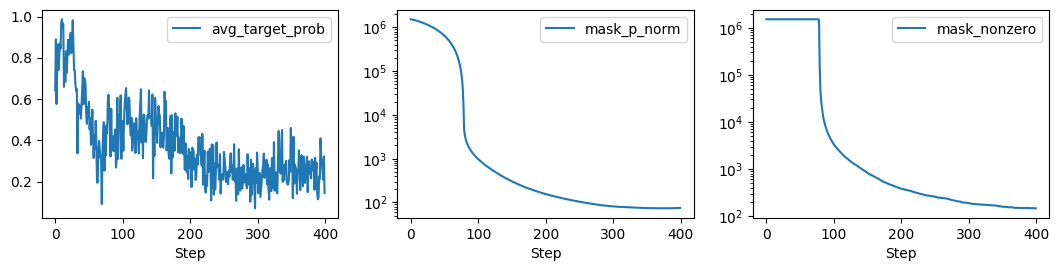

In [14]:
df = pd.DataFrame(metric_history)

plt.figure(figsize=(13, 2.7))
plt.subplot(1, 3, 1)
df.avg_target_prob.plot()
plt.legend()
plt.xlabel("Step")

plt.subplot(1, 3, 2)
df.mask_p_norm.plot()
plt.yscale("log")
plt.legend()
plt.xlabel("Step")

plt.subplot(1, 3, 3)
df.mask_nonzero.plot()
plt.yscale("log")
plt.legend()
plt.xlabel("Step")

plt.show()

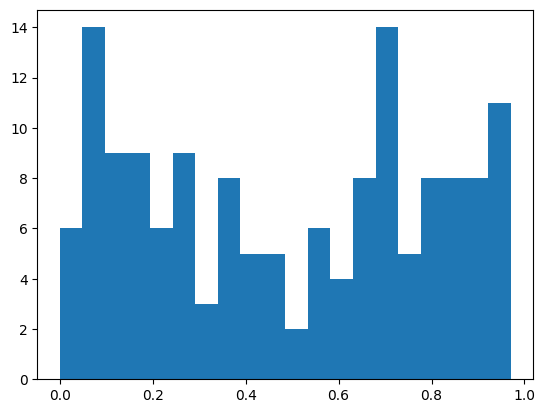

In [15]:
# Analyze performance on multiple people
mtf.eval()
with torch.no_grad():
    logits = mtf.tl_model.forward(all_prompt_tokens, return_type="logits")[:, -1]
    target_probs = torch.softmax(logits, dim=-1)[
        torch.arange(len(all_correct_tokens)), all_correct_tokens
    ].detach().cpu().numpy()

plt.hist(target_probs, bins=20)
plt.show()

In [21]:
mtf.eval()
prompt = all_prompts[27]
print(prompt)
utils.get_top_responses(
    prompt=prompt,
    model=mtf.tl_model,
    top_k=5,
    use_kv_cache=False,
    n_continuation_tokens=1,
)

[INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>

Complete the statement. Xavien Howard plays the sport of [/INST] 
Rank 0. Logit: 22.25 Prob: 71.95% Tokens: (21850) |Basketball|ss|
Rank 1. Logit: 20.75 Prob: 16.09% Tokens: (23185) |Baseball|/|
Rank 2. Logit: 20.04 Prob:  7.89% Tokens: ( 8914) |Football|丸|
Rank 3. Logit: 18.98 Prob:  2.74% Tokens: (29010) |Tennis|/|
Rank 4. Logit: 17.34 Prob:  0.53% Tokens: (20305) |basketball|ss|


(21850, 'Basketball')

### Visualize remaining flow

In [22]:
attn_mask = np.stack(
    [mtf.masks[f"{i}_attn_out"].detach().cpu().numpy() for i in range(32)]
)
attn_z_mask = np.stack(
    [mtf.masks[f"{i}_attn_z"].detach().cpu().numpy() for i in range(32)], axis=0
)
attn_pattern_mask = np.stack(
    [mtf.masks[f"{i}_attn_pattern"].detach().cpu().numpy() for i in range(32)],
)
mlp_mask = np.stack(
    [mtf.masks[f"{i}_mlp_out"].detach().cpu().numpy() for i in range(32)]
)

attn_z_mask *= (attn_mask > 0)[:, :, np.newaxis]
attn_mask.shape, attn_z_mask.shape, attn_pattern_mask.shape, mlp_mask.shape

((32, 53), (32, 53, 32), (32, 32, 53, 53), (32, 53))

<s>|[|INST|]|<<|SY|S|>>|
|You|are|an|assistant|who|only|respond|s|with|a|single|word|.|You|only|give|correct|answers|.|
|<|</|SY|S|>>|
|
|Complete|the|statement|.|X|av|ien|Howard|plays|the|sport|of|[|/|INST|]|
Layer 0, head 26, token 0: weight=0.089767426
Layer 0, head 9, token 27: weight=0.32026735
Layer 0, head 28, token 27: weight=0.6583492
Layer 0, head 25, token 52: weight=1.0
Layer 1, head 24, token 43: weight=0.65529114
Layer 1, head 27, token 43: weight=0.92388374
Layer 1, head 8, token 46: weight=0.46117666
Layer 1, head 22, token 52: weight=0.021262674
Layer 2, head 2, token 43: weight=0.41466808
Layer 2, head 13, token 43: weight=0.14672478
Layer 2, head 17, token 43: weight=0.5762114
Layer 3, head 5, token 51: weight=0.5064808
Layer 3, head 28, token 52: weight=0.98730224
Layer 4, head 10, token 20: weight=0.3555537
Layer 4, head 17, token 43: weight=0.10509618
Layer 4, head 8, token 52: weight=1.0
Layer 4, head 27, token 52: weight=0.8656259
Layer 5, head 26, token 20: wei

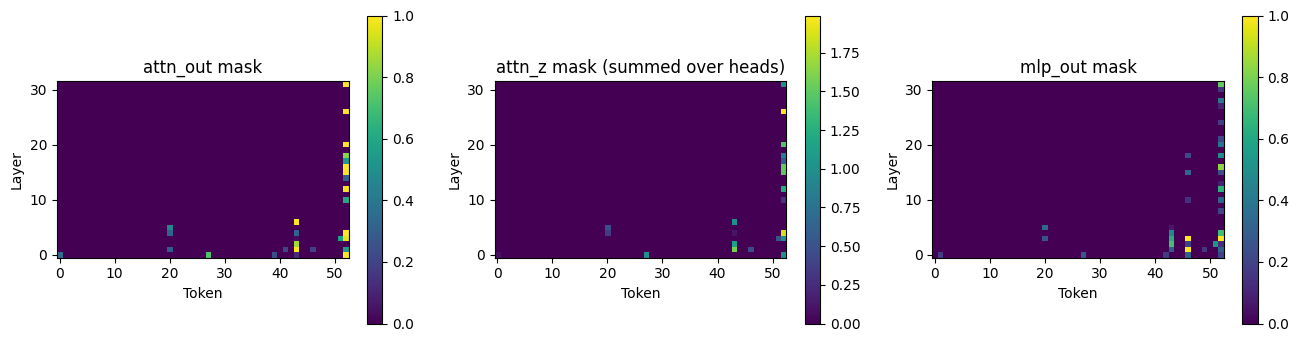

In [23]:
# Plot heatmap of attention mask
subtokens = mtf.tl_model.to_tokens(prompt)[0, mtf.mask_start_idx :]
tokenized_subprompt = "|".join(mtf.tl_model.to_string(x) for x in subtokens)
print(tokenized_subprompt)

for layer_idx in range(32):
    for token_idx in range(mtf.n_tokens):
        for head_idx in range(mtf.tl_model.cfg.n_heads):
            weight = attn_z_mask[layer_idx, token_idx, head_idx]
            if weight > 0:
                print(
                    f"Layer {layer_idx},"
                    f" head {head_idx},"
                    f" token {token_idx}:"
                    f" {weight=}"
                )

for layer_idx in range(32):
    for head_idx in range(mtf.tl_model.cfg.n_heads):
        for token_idx_q in range(mtf.n_tokens):
            for token_idx_k in range(mtf.n_tokens):
                weight = attn_pattern_mask[
                    layer_idx, head_idx, token_idx_q, token_idx_k
                ]
                if weight > 0:
                    q_token = mtf.tl_model.to_string(subtokens[token_idx_q])
                    k_token = mtf.tl_model.to_string(subtokens[token_idx_k])
                    print(
                        f"Layer {layer_idx},"
                        f" head {head_idx},"
                        f" token_q {token_idx_q} ({q_token})"
                        f" token_k {token_idx_k} ({k_token}):"
                        f" {weight=}"
                    )

plt.figure(figsize=(16, 4))
# plt.suptitle(tokenized_subprompt)

plt.subplot(1, 3, 1)
plt.imshow(attn_mask, origin="lower")
plt.xlabel("Token")
plt.ylabel("Layer")
plt.colorbar()
plt.title("attn_out mask")

plt.subplot(1, 3, 2)
plt.imshow(attn_z_mask.sum(axis=-1), origin="lower")
plt.xlabel("Token")
plt.ylabel("Layer")
plt.colorbar()
plt.title("attn_z mask (summed over heads)")

plt.subplot(1, 3, 3)
plt.imshow(mlp_mask, origin="lower")
plt.xlabel("Token")
plt.ylabel("Layer")
plt.colorbar()
plt.title("mlp_out mask")

plt.show()

### Analyze thresholding

In [24]:
all_mask_values = (
    torch.cat([mask.flatten() for mask in mtf.masks.values()])
    .detach()
    .cpu()
    .numpy()
)

thresholds = np.unique(
    np.sort(np.concatenate([np.sort(all_mask_values)[::10], np.array([0, 1])]))
)
thresh_metrics = []
for thresh in tqdm(thresholds):
    mtf.zero_threshold = thresh
    mtf.one_threshold = 1
    with torch.no_grad():
        target_probs_0 = mtf.tl_model.forward(
            all_prompt_tokens, return_type="logits"
        )[:, -1].softmax(dim=-1)[
            range(len(all_correct_tokens)), all_correct_tokens
        ].mean()

    mtf.zero_threshold = 0
    mtf.one_threshold = max(thresh, 1e-9)
    with torch.no_grad():
        target_probs_1 = mtf.tl_model.forward(
            all_prompt_tokens, return_type="logits"
        )[:, -1].softmax(dim=-1)[
            range(len(all_correct_tokens)), all_correct_tokens
        ].mean()

    thresh_metrics.append(
        dict(
            threshold=thresh,
            target_prob_0=target_probs_0.item(),
            target_prob_1=target_probs_1.item(),
            n_nonzero=(all_mask_values > thresh).sum(),
            n_ones=(all_mask_values > thresh).sum(),
        )
    )

  0%|          | 0/14 [00:00<?, ?it/s]

# nonzero mask values: 146
# total mask values: 2934080


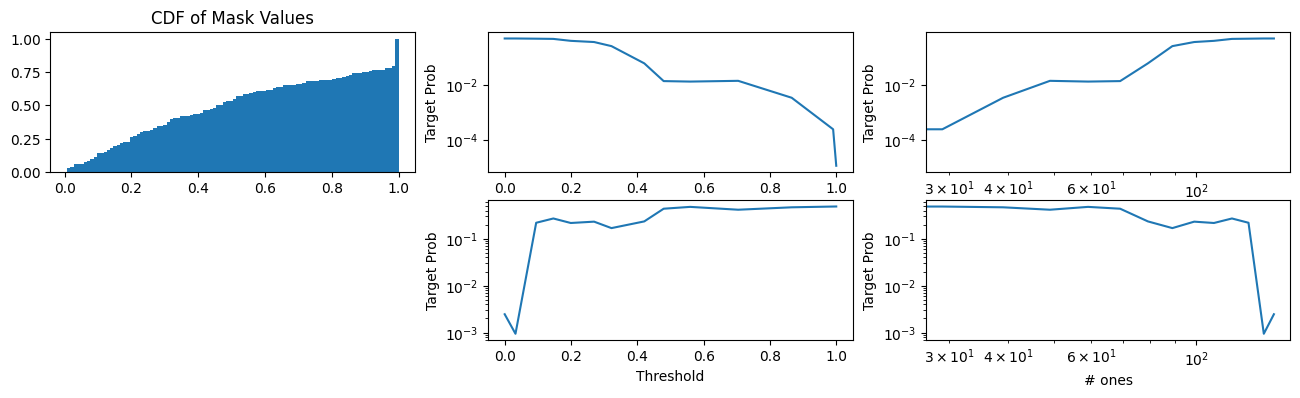

In [25]:
df_thresh = pd.DataFrame(thresh_metrics)

print("# nonzero mask values:", (all_mask_values > 0).sum())
print("# total mask values:", all_mask_values.size)

plt.figure(figsize=(16, 4))
plt.subplot(2, 3, 1)
plt.hist(
    all_mask_values[all_mask_values > 0],
    cumulative=True,
    bins=100,
    density=True,
)
plt.title("CDF of Mask Values")

plt.subplot(2, 3, 2)
plt.plot(df_thresh.threshold, df_thresh.target_prob_0)
plt.yscale("log")
plt.xlabel("0 Threshold")
plt.ylabel("Target Prob")

plt.subplot(2, 3, 3)
plt.plot(df_thresh.n_nonzero, df_thresh.target_prob_0)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# non-zero mask values")
plt.ylabel("Target Prob")

plt.subplot(2, 3, 5)
plt.plot(df_thresh.threshold, df_thresh.target_prob_1)
plt.yscale("log")
plt.xlabel("Threshold")
plt.ylabel("Target Prob")

plt.subplot(2, 3, 6)
plt.plot(df_thresh.n_ones, df_thresh.target_prob_1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# ones")
plt.ylabel("Target Prob")
plt.show()